# Table of Contents
- [0. Problem statement and importing relevant modules](#0.-Problem-statement-and-importing-relevant-modules)
- [1. Loading and visualising the dataset](#1.-Loading-and-visualising-the-dataset)
- [2. Setting up a simple model architecture](#2.-Setting-up-a-simple-model-architecture)
- [3. Building and training our model](#3.-Building-and-training-our-model)
    - [3.1 Understanding and implementing forward propogation](#3.1-Understanding-and-implementing-forward-propogation)
    - [3.2 The cross-entropy loss function](#3.2-The-cross-entropy-loss-function)
    - [3.3 Understanding and implementing back propogation](#3.3-Understanding-and-implementing-back-propogation)
    - [3.4 Updating paramaters through gradient descent](#3.4-Updating-paramaters-through-gradient-descent)
    - [3.5 Putting it all together - defining the function that will train our model over multiple epochs](#3.5-Putting-it-all-together---defining-the-function-that-will-train-our-model-over-multiple-epochs)
- [4. Running our model and evaluating its performance](#4.-Running-our-model-and-evaluating-its-performance)
    - [4.1 Training the model](#4.1-Training-the-model)
    - [4.2 Evaluating model performance](#4.2-Evaluating-model-performance)
    - [4.3 Brief conclusion and discussion of possible improvements](#4.3-Brief-conclusion-and-discussion-of-possible-improvements)
- [5. Acknowledgements](#5.-Acknowledgements)

# 0. Problem statement and importing relevant modules

**Problem Statement:** The goal is to build a simple multilayer perceptron (neural network) model from first principles and use it to effectively classify/identify handwritten images of single number digits.

**Why?** To showcase an understanding of the fundamental algorithms (e.g. forward prop, back prop, gradient descent) underpinning neural networks often overlooked when implementing neural nets utilising TensorFlow, Keras etc.

**These are the only modules I will be using to build the model:**

In [1]:
import numpy as np  # for linear algebra operations
import matplotlib.pyplot as plt  # for some plots
import time # to check how long it takes our final model to train

# 1. Loading and visualising the dataset

I will be using the MNIST database of handwritten digits. This provides me with a training set of 60,000 examples, and a test set of 10,000 examples.
Four files are available:

**train-images.idx3-ubyte:** training set images (set of 60,000 28x28 matrices comprised of integrers between [0,255] depicting the intensity of each pixel)  
**train-labels.idx1-ubyte:** training set labels (set of 60,000 integers y=0,1,...,9 depicting what number an image is)  
**t10k-images-idx3-ubyte:** test set images (set of 10,000 28x28 matrices comprised of integrers between [0,255] depicting the intensity of each pixel)  
**t10k-labels.idx1-ubyte:** test set labels (set of 10,000 integers y=0,1,...,9 depicting what number an image is)  

**First I define a function to load and store the training and test data into seperate variables:**

In [2]:
def read_images(filename):
    with open(filename, 'rb') as f:  
        magic, num_images = np.frombuffer(f.read(8), dtype=np.uint32).byteswap() 
        rows, cols = np.frombuffer(f.read(8), dtype=np.uint32).byteswap()  
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)  
    return images  # return images array

def read_labels(filename):
    with open(filename, 'rb') as f:  
        magic, num_labels = np.frombuffer(f.read(8), dtype=np.uint32).byteswap()  
        labels = np.frombuffer(f.read(), dtype=np.uint8)  
    return labels  # return labels array

# file paths for data
train_images_file = 'train-images.idx3-ubyte'
train_labels_file = 'train-labels.idx1-ubyte'
test_images_file = 't10k-images-idx3-ubyte'
test_labels_file = 't10k-labels.idx1-ubyte'

# loading the training and test images and labels
train_images = read_images(train_images_file)
train_labels = read_labels(train_labels_file)
test_images = read_images(test_images_file)
test_labels = read_labels(test_labels_file)


**Since the MNIST data stores pixel intensity in the form of numbers between [0,255], it makes sense to normalise the data set to fit a [0,1] scale. This will help the model to learn easier and accelerate the training process:**

In [3]:
train_images = train_images / 255.0  # normalise training set by dividing by max pixl value
test_images = test_images / 255.0  # normalise test set by dividing by max pixl value

**Let us visualise a sample of our training data. I utilise matplotlib colour map function to plot 25 images and their corresponding label:**

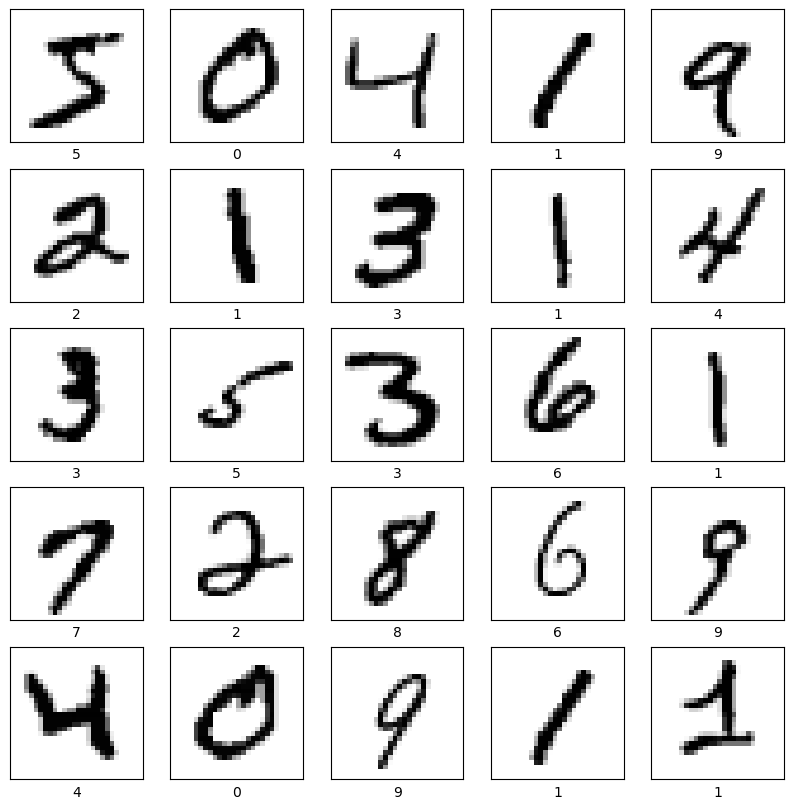

In [4]:
def plot_images(images, labels):
    plt.figure(figsize=(10,10))  
    for i in range(25):  # 25 image sample
        plt.subplot(5,5,i+1)  
        ###asethetics only
        plt.xticks([])  # remove x-axis
        plt.yticks([])  # remove y-axis 
        plt.grid(False)  # disable grid
        ###
        plt.imshow(images[i].reshape(28,28), cmap=plt.cm.binary)  # reshape arrays and plot using colour map
        plt.xlabel(labels[i])  # assign label to corresponding image
    plt.show()  

# plot 25 image sample of our training set
plot_images(train_images, train_labels)

# 2. Setting up a simple model architecture

I define a simple neural network model architecture for the purposes of our task:

- An input layer with 784 neurons (one for each pixel in each 28x28=784 input image).  
- One hidden layer with 32 neurons. 
- An output layer with 10 neurons, each representing a class for the digits 0 to 9.  

We'll use the ReLU activation function for the hidden layer and the softmax function for the output layer to calculate the probabilities. 

**To start off we build a code to define the model architecture described above and we initialise the weights and biases.** 

**Note two things:**  
1. **we initialise our weights ($W1$,$W2$) using small random numbers from a normal distribution multiplied by 1%. This keeps the initial weights small reducing the risk of an "exploding" gradient during back-prop.**  
2. **we set our biases ($b1$, $b2$) to zero. This can be done differently but it simplifies the initial state of the network.**  

In [5]:
# size (i.e. # of neurons) for each layer
input_size = 784  # 28x28=784 neurons in input layer
hidden_size = 32  # 32 neurons in hidden layer. Why 32? Because it works... larger models will yield better results but for our purposes this is ok.
output_size = 10  # 10 neurons in output layer, one for each digit 0,1,...9

# initiallising out weights and biases
def initialize_weights(input_size, hidden_size, output_size):
    # initialise weights with small random values from a normal distribution
    W1 = np.random.randn(input_size, hidden_size) * 0.01  # weights from input to hidden layer
    b1 = np.zeros((1, hidden_size))  # biases for hidden layer for simplicity set to be zero at start 
    W2 = np.random.randn(hidden_size, output_size) * 0.01  # weights from hidden to output layer
    b2 = np.zeros((1, output_size))  # biases for output layer, also set to zero
    
    return W1, b1, W2, b2

# initialise the network parameters
W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)

**We also define our ReLU (hidden layer) and softmax (output layer) activation functions:**

In [6]:
# reulu activation function
def relu(Z):
    return np.maximum(0, Z)  

# softmax activation function
def softmax(Z):
    expZ = np.exp(Z - np.max(Z))  
    return expZ / expZ.sum(axis=1, keepdims=True)  

# 3. Building and training our model

### 3.1 Understanding and implementing forward propogation

Forward prop, in the context of our specific model, follows these steps:

1) given our initial input layer weights $W1$, biases $b1$ and training data $X$, we calculate the output of our input layer/ input of our hidden layer $Z1$ by calculating the linear product: $Z1 = X.W1+b1$
2) We apply the relu function to our linear object $Z1$ to obtain the activation array of the hidden layer $A1=relu(Z1)$.
3) Given our initial hidden layer weights $W2$, biases $b2$ and "new" input data $A1$, we calculate the output of our hidden layer/ input of our output layer $Z2$ by calculating the linear product: $Z2 = A1.W2+b2$
4) We apply the softmax activation function to our linear object $Z2$ to obtain the activation of the output layer $A2=softmax(Z2)$.
5) We will store our values $Z1$, $A1$, $Z2$ and $A2$ for use in backprog later on.

In [7]:
def forward_propagation(X, W1, b1, W2, b2):
    # hidden layer input
    Z1 = np.dot(X, W1) + b1  # Z1 = XW1 + b1
    # hidden layer activation
    A1 = relu(Z1)  
    # output layer input
    Z2 = np.dot(A1, W2) + b2  # Z2 = A1W2 + b2
    # output layer activation 
    A2 = softmax(Z2)  
    
    cache = (Z1, A1, Z2, A2)  # store values for later use in backprop
    return A2, cache

### 3.2 The cross-entropy loss function

**Let us define a loss function which will act as a baseline for how well our model is performing post-training. We use a cross-entropy loss fn which is commonly used in mutually exclusive multiclass classification tasks:**

$$L = -\sum_{i=1}^{10} y_i \log(A_i)$$

where:
- $A_i$ represents the our models predicted probability of each class for a given input $X_i$. This is calculated using the softmax function for class $i$:

$$A_i = \frac{e^{Z_i}}{\sum_{k=1}^{10} e^{Z_k}}$$

- $y_i$ is a binary indicator (0 or 1) if class label $i$ is the correct classification for $X_i$.
- $Z_i$ are the outputs from the final layer before applying the softmax.

**Note:** when the correct label for $X_i$ is class $j$, the loss function simplifies to:

$$L = -\log(A_j)$$

In [8]:
'''note our function compares the output layers activations 
- A2 (which is our models probabilities associated to each digit 0,1,...,9) to the actual values held in Y.'''
def compute_loss(Y, A2):
    m = Y.shape[0]  # number of examples stored in Y.
    log_likelihoods = -np.log(A2[range(m), Y])  # only select the log probability of the true class
    loss = np.sum(log_likelihoods) / m  # average loss across all examples
    return loss

### 3.3 Understanding and implementing back propogation

Backpropagation is the method I use to compute gradients of the loss function with respect to each parameter (weights and biases) in the network, done by applying the chain rule systematically across all layers. This process is crucial for optimising the neural network during training by making it possible to minimise the loss function through gradient descent.

Backprop, in the context of our specific model, follows these steps:

1. **Compute $( \frac{{dZ2}}{{dL}} )$**: We begin by calculating the gradient of the loss function wrt the pre-activation values of the output layer, denoted as $dZ2$.

2. **Update $W2$ and $b2$**: Using the chain rule, we derive the update rule for $W2$ as follows:
   
   $$ dW2 = \frac{{dL}}{{dW2}} = \frac{{dL}}{{dZ2}} \cdot \frac{{dZ2}}{{dW2}} = dZ2 \cdot A1 $$

   Here, $dW2$ represents the gradient of the loss with respect to the weights $W2$, and $A1$ represents the activation of the hidden layer. Since $Z2 = A1W2 + b2$, the derivative $\frac{{dZ2}}{{dW2}}$ simplifies to $A1$.

3. **Calculate $\frac{{dL}}{{dA1}}$**: Next, we compute the gradient of the loss function with respect to the activation of the hidden layer, denoted as $dA1$.

4. **Update $W1$ and $b1$**: Similarly to step 2, we derive the update rule for $W1$ using the chain rule:
   
   $$ dW1 = \frac{{dL}}{{dW1}} = \frac{{dL}}{{dZ1}} \cdot \frac{{dZ1}}{{dW1}} = dZ1 \cdot X $$

   Here, $dW1$ represents the gradient of the loss wrt the weights $W1$, and $X$ represents the input data. Since $Z1 = XW1 + b1$, the derivative $\ \frac{{dZ1}}{{dW1}}$ simplifies to $X$.

In [9]:
def backpropagation(X, Y, cache, W1, W2):
    Z1, A1, Z2, A2 = cache
    m = X.shape[0]

    # gradient of loss wrt output layer inputs (Z2_i)
    dZ2 = A2
    dZ2[range(m), Y] -= 1
    dZ2 /= m

    # gradients of loss wrt weights (W2) and biases (b2) of the output layer
    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    # gradient of loss wrt hidden layer output (A1)
    dA1 = np.dot(dZ2, W2.T)
    # gradient of loss wrt hidden layer inputs (Z1_i)
    dZ1 = dA1 * (Z1 > 0)  # right-hand term is the derivative of ReLU

    # gradients of loss wrt weights (W1) and biases (b1) of hidden layers
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2


### 3.4 Updating paramaters through gradient descent

Here is the step-by-step gradient descent process:

1. We take as inputs the current values of the params ($W1$, $b1$, $W2$, $b2$), the gradients of the loss function wrt each param ($dW1$, $db1$, $dW2$, $db2$) (calculated during back prop), and the learning rate $η$,
2. We update each param using gradient descent. For example, the updated weights of the first layer ($W1'$) are computed as below:
$$W1' = W1 - η.dW1$$,
3. The learning rate $η$ controls the size of the steps taken during gradient descent.

In [10]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

### 3.5 Putting it all together - defining the function that will train our model over multiple epochs

We'll wrap the full process (from initialisation, to forward prop & backward prop) into a loop that allows us to train the network over multiple epochs.

In [11]:
def model(X, Y, hidden_size=32, output_size=10, num_epochs=25, learning_rate=0.01):
    """Train the neural network model."""
    input_size = X.shape[1]  # Assuming X is [n_samples, n_features]
    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)

    start_time = time.time()  # Start timing
    
    for epoch in range(num_epochs):
        A2, cache = forward_propagation(X, W1, b1, W2, b2)
        cost = compute_loss(Y, A2)
        dW1, db1, dW2, db2 = backpropagation(X, Y, cache, W1, W2)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {cost:.6f}")

    end_time = time.time()  # End timing
    duration = end_time - start_time  # Calculate duration
    print(f"Training completed in {duration:.2f} seconds")

    return W1, b1, W2, b2

### 4. Running our model and evaluating its performance

### 4.1 Training the model

In [12]:
# Training the model
W1, b1, W2, b2 = model(train_images, train_labels, hidden_size=32, output_size=10, num_epochs=500, learning_rate=0.5)




Epoch 0, Loss: 2.302667
Epoch 50, Loss: 0.666412
Epoch 100, Loss: 0.353140
Epoch 150, Loss: 0.300133
Epoch 200, Loss: 0.272063
Epoch 250, Loss: 0.250767
Epoch 300, Loss: 0.232860
Epoch 350, Loss: 0.217434
Epoch 400, Loss: 0.204139
Epoch 450, Loss: 0.192440
Training completed in 89.45 seconds


### 4.2 Evaluating model performance

In [13]:
def accuracy(predictions, labels):
    """calculate the accuracy of the predictions."""
    return np.mean(predictions == labels)

def predict(X, W1, b1, W2, b2):
    """make predictions using the trained weights and biases."""
    _, (_, _, _, A2) = forward_propagation(X, W1, b1, W2, b2)
    predictions = np.argmax(A2, axis=1)
    return predictions

In [14]:
# Making predictions on the training set
train_predictions = predict(train_images, W1, b1, W2, b2)
train_accuracy = accuracy(train_predictions, train_labels)
print(f"Training Set Accuracy: {train_accuracy * 100:.2f}%")



Training Set Accuracy: 94.92%


In [15]:
# Making predictions on the test set
test_predictions = predict(test_images, W1, b1, W2, b2)
test_accuracy = accuracy(test_predictions, test_labels)
print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")

Test Set Accuracy: 94.70%


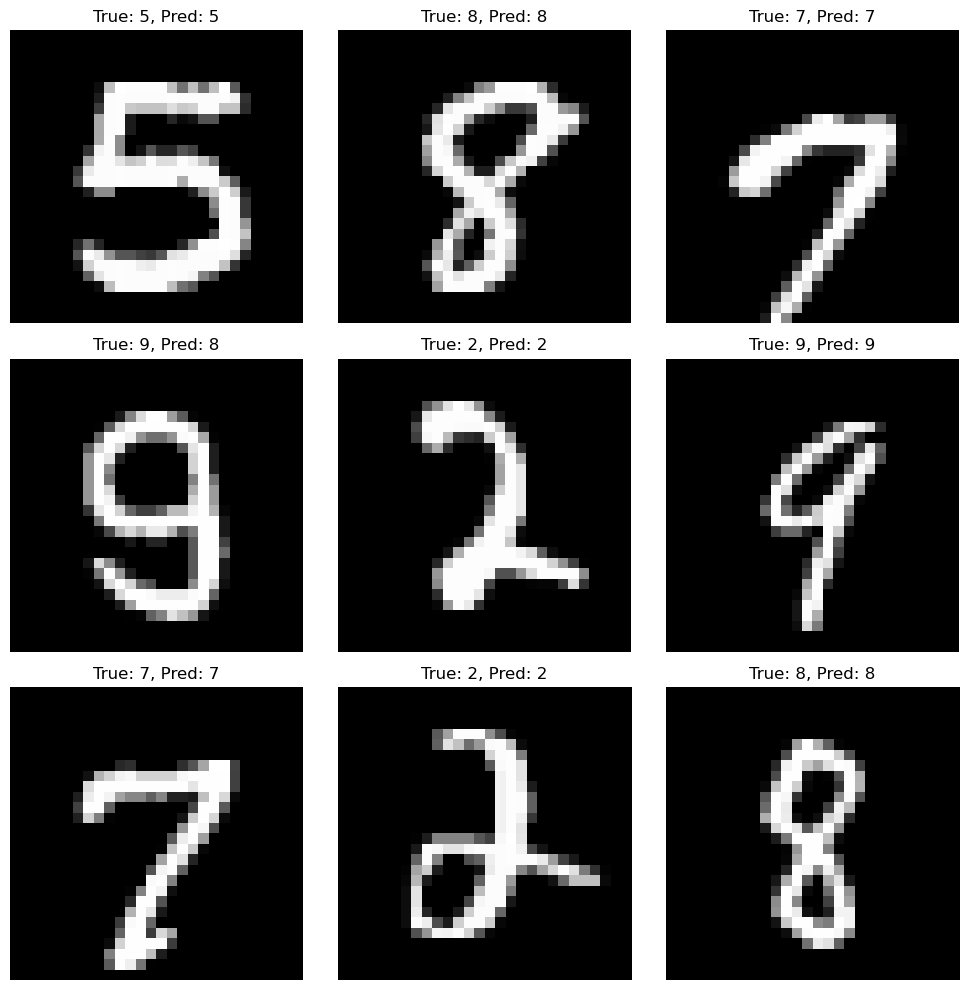

In [18]:
def plot_sample_images(images, labels, predictions):
    # Select 9 random images
    indices = np.random.choice(np.arange(images.shape[0]), 9, replace=False)
    
    # Create a grid plot with 3x3 subplots
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(indices):
        plt.subplot(3, 3, i + 1)
        image = images[index].reshape(28, 28)  # Reshape the image to 28x28
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {labels[index]}, Pred: {predictions[index]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Making predictions on a subset of the test set
subset_predictions = predict(test_images, W1, b1, W2, b2)

# Call the function with test images, true labels, and predictions
plot_sample_images(test_images, test_labels, subset_predictions)

### 4.3 Brief conclusion and discussion of possible improvements

1) Our results are promising, we have built a model with approx. 94% accruacy across both training and test sets. This suggests good stability and ability to learn effectively with fairly limited computational power and model complexity.

2) You can see in the plots above 9 examples of our model predictions and associated images. You can see that the type of pictures the models struggles to identify (e.g. the example (True:9, Pred:8)) are ones where you could almost forgive it for making a mistake. After all, that 9 does look a bit like an 8!

3) There are many steps we can take to improve the model accuracy by helping it to better identify these more complex images. But since the goal of this project was to showcase the fundamental concepts governing neural networks, I leave these improvements for another time.

For those curious, here are three fairly simple ways to improve the model:
- **Increase the number of layers and/or neurons.** At the cost of some minor computational speed, introducing more layers/neurons will help the model better distinguish more complex patterns/images.
- **Increase the number of epochs.** There is clearly diminishing marginal returns to running more epochs on minimising the cost function but a fairly simple way to gain an extra 1-2% of performance is by increasing the number of epochs. Note, this comes at a non-negligible training time cost.
- **Alternative learning rates.** Instead of using a constant learning rate, we could use adaptive learning rate methods e.g. Adams, which help converge faster.


# 5. Acknowledgements

Data downloaded from Kaggle: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

**Acknowledgements as per Kaggle website:**

- Yann LeCun, Courant Institute, NYU
- Corinna Cortes, Google Labs, New York
- Christopher J.C. Burges, Microsoft Research, Redmond